In [ ]:
!pip install ptan

     |████████████████████████████████| 773.1MB 23kB/s 
  Created wheel for ptan: filename=ptan-0.6-cp36-none-any.whl size=23502 sha256=fb51ea25dbcd9b2228058259584e056d7207cb70e1a23baf686fa11f5505f108
  Stored in directory: /root/.cache/pip/wheels/f0/4b/2f/9a45fd39b0a614a2716bc6128a7f1adb4647f323a2d90783f2
Successfully built ptan
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [ ]:
import gym
import ptan
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
TGT_NET_SYNC = 10
GAMMA = 0.9
REPLAY_SIZE = 1000
LR = 1e-3
EPS_DECAY=0.99

In [ ]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.float())

In [ ]:
@torch.no_grad()
def unpack_batch(batch, net, gamma):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states)
    actions_v = torch.tensor(actions)
    rewards_v = torch.tensor(rewards)
    last_states_v = torch.tensor(last_states)
    last_state_q_v = net(last_states_v)
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v * gamma + rewards_v

In [ ]:
if __name__ == "__main__":
    env = gym.make("CartPole-v0")
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    net = Net(obs_size, HIDDEN_SIZE, n_actions)
    tgt_net = ptan.agent.TargetNet(net)
    selector = ptan.actions.ArgmaxActionSelector()
    selector = ptan.actions.EpsilonGreedyActionSelector(
        epsilon=1, selector=selector)
    agent = ptan.agent.DQNAgent(net, selector)
    exp_source = ptan.experience.ExperienceSourceFirstLast(
        env, agent, gamma=GAMMA)
    buffer = ptan.experience.ExperienceReplayBuffer(
        exp_source, buffer_size=REPLAY_SIZE)
    optimizer = optim.Adam(net.parameters(), LR)

    step = 0
    episode = 0
    solved = False

    while True:
        step += 1
        buffer.populate(1)

        for reward, steps in exp_source.pop_rewards_steps():
            episode += 1
            print("%d: episode %d done, reward=%.3f, epsilon=%.2f" % (
                step, episode, reward, selector.epsilon))
            solved = reward >= 200
        if solved:
            print("Congrats!")
            break

        if len(buffer) < 2*BATCH_SIZE:
            continue

        batch = buffer.sample(BATCH_SIZE)
        states_v, actions_v, tgt_q_v = unpack_batch(
            batch, tgt_net.target_model, GAMMA)
        optimizer.zero_grad()
        q_v = net(states_v)
        q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
        loss_v = F.mse_loss(q_v, tgt_q_v)
        loss_v.backward()
        optimizer.step()
        selector.epsilon *= EPS_DECAY

        if step % TGT_NET_SYNC == 0:
            tgt_net.sync()

37: episode 1 done, reward=36.000, epsilon=0.95
79: episode 2 done, reward=42.000, epsilon=0.62
97: episode 3 done, reward=18.000, epsilon=0.52
113: episode 4 done, reward=16.000, epsilon=0.44
128: episode 5 done, reward=15.000, epsilon=0.38
141: episode 6 done, reward=13.000, epsilon=0.33
165: episode 7 done, reward=24.000, epsilon=0.26
176: episode 8 done, reward=11.000, epsilon=0.24
187: episode 9 done, reward=11.000, epsilon=0.21
197: episode 10 done, reward=10.000, epsilon=0.19
210: episode 11 done, reward=13.000, epsilon=0.17
220: episode 12 done, reward=10.000, epsilon=0.15
233: episode 13 done, reward=13.000, epsilon=0.13
243: episode 14 done, reward=10.000, epsilon=0.12
254: episode 15 done, reward=11.000, epsilon=0.11
264: episode 16 done, reward=10.000, epsilon=0.10
274: episode 17 done, reward=10.000, epsilon=0.09
284: episode 18 done, reward=10.000, epsilon=0.08
295: episode 19 done, reward=11.000, epsilon=0.07
307: episode 20 done, reward=12.000, epsilon=0.06
319: episode

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if(IN_COLAB):
    !apt update
    !apt install xvfb
    !pip install gym-notebook-wrapper
    import gnwrapper

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.1 kB]
Get:13 http://ppa.launchpad.net/graph

Total score: 200.0


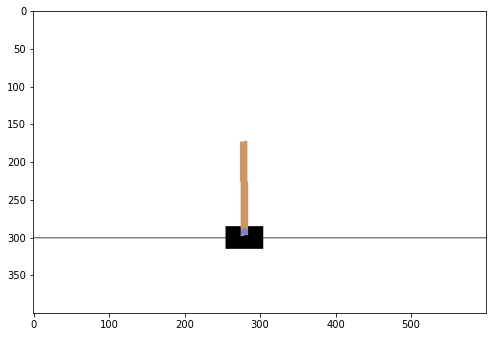

In [ ]:
import numpy as np

#env = gnwrapper.Monitor(gym.make('CartPole-v0'), directory="./") # Start Xvfb
#env = gnwrapper.Animation(gym.make('CartPole-v0')) # Start Xvfb
env = gnwrapper.LoopAnimation(gym.make('CartPole-v0')) # Start Xvfb

# See our trained network in action
observation = env.reset()
reward_sum = 0
done =  False
while not done:
    env.render()
    x = np.reshape(observation, [1, obs_size])
    x_torch = torch.FloatTensor(x)
    Q = net(x_torch)
    action = np.argmax(Q.detach().numpy())

    observation, reward, done, _ = env.step(action)
    reward_sum += reward

print("Total score: {}".format(reward_sum))
env.display() # Display saved display images as animation

In [ ]:
env.close()